### Common imports

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sklearn
print("sklearn version is "+sklearn.__version__)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

sklearn version is 0.22.1


If the sklearn version is <0.2, need to use ``future_encoders`` in various places in the following code.

### Data acquisition

In [2]:
pwd

'/Users/souvikdutta/Desktop/Amazon_Fires'

In [3]:
import pandas as pd
fires=pd.read_csv('/Users/souvikdutta/Desktop/Amazon_Fires/amazon-dataset.csv')

In [4]:
fires.head()

,year,state,month,number,date
0,1998,Acre,Janeiro,0.0,1998-01-01
1,1999,Acre,Janeiro,0.0,1999-01-01
2,2000,Acre,Janeiro,0.0,2000-01-01
3,2001,Acre,Janeiro,0.0,2001-01-01
4,2002,Acre,Janeiro,0.0,2002-01-01


In [5]:
fires.shape

(6454, 5)

### Preliminary analysis

Let's first check if there are any missing values

In [6]:
np.vstack((fires.isna().any(),fires.isnull().any()))

array([[False, False, False, False, False],
       [False, False, False, False, False]])

In [7]:
fires.dtypes

year        int64
state      object
month      object
number    float64
date       object
dtype: object

No non-null objects. However, ``year``, ``state`` and ``date`` are objects..

In [8]:
print("Year range:",fires["year"].min(), "to",fires["year"].max())

Year range: 1998 to 2017


In [9]:
fires["state"].value_counts().head(9)

Rio                 717
Mato Grosso         478
Paraiba             478
Alagoas             240
Sao Paulo           239
Amazonas            239
Pernambuco          239
Santa Catarina      239
Distrito Federal    239
Name: state, dtype: int64

In [10]:
fires["year"].value_counts().head(5)

2015    324
2011    324
2004    324
2008    324
2012    324
Name: year, dtype: int64

The datapoints (not the number of fires!) per state is capped at 239 in most states, and at 324 per year. 

### Randomised test-train Split

Split into 20-80 test-train sets using sklearn's built-in function. I cannot see an obvious reason to ``StratifiedShuffleSplit`` instead.

In [11]:
from sklearn.model_selection import train_test_split
train_set,test_set =train_test_split(fires,test_size=0.2,random_state=20)
print(train_set.shape,test_set.shape)

(5163, 5) (1291, 5)


In [12]:
train_set.head()

,year,state,month,number,date
4283,2017,Piau,Novembro,449.0,2017-01-01
1647,2010,Distrito Federal,Novembro,0.0,2010-01-01
5993,2015,Sergipe,Janeiro,44.0,2015-01-01
6091,2013,Sergipe,Junho,1.0,2013-01-01
4419,2014,Rio,Junho,54.0,2014-01-01


### Explore/Visualize the data

#### Fires per year

In [13]:
yfire=pd.DataFrame(fires, columns = ["year","number"]); #new DataFrame
nyears=fires["year"].max()-fires["year"].min()+1; #total number of years
ylist=np.linspace(fires["year"].min(),fires["year"].max(),nyears) #list of all data years

In [14]:
isfire=np.zeros(nyears) #initialize fire counts 
for i in ylist:
    isfire[np.int(i-fires["year"].min())]=np.sum(yfire.number[yfire["year"]==i])

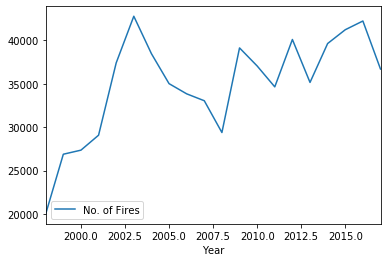

In [16]:
import matplotlib.pyplot as plt

d = {'Year': ylist, 'No. of Fires': isfire}
df = pd.DataFrame(data=d)
df.plot(x="Year",y="No. of Fires",figsize=(6,4),rot=0)
plt.show()

#### Fires over months

In [20]:
mfire=pd.DataFrame(fires, columns = ["month","number"]); #new DataFrame
mlist=list(set(mfire["month"])) #set of all months

In [21]:
isfire=np.zeros(12) #initialize fire counts 
for i in mlist:
    isfire[mlist.index(i)]=np.sum(mfire.number[mfire["month"]==i])

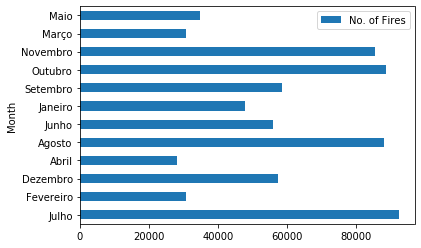

In [22]:
d = {'Month': mlist, 'No. of Fires': isfire}
df = pd.DataFrame(data=d)
df.plot(x="Month",y="No. of Fires",kind="barh",figsize=(6,4),rot=0)
plt.show()

This shows that post-summer months are usually vulnerable to fires.

#### Study correlations between attributes

In [28]:
fires.corr(method='pearson')

,year,number
year,1.000000,0.065201
number,0.065201,1.000000


Seems like the yearly correlations aren't that great.

### Prepare the data

In [52]:
np.zeros(3,dtype=bool)

array([False, False, False])

In [29]:
train_set.head()

,year,state,month,number,date
4283,2017,Piau,Novembro,449.0,2017-01-01
1647,2010,Distrito Federal,Novembro,0.0,2010-01-01
5993,2015,Sergipe,Janeiro,44.0,2015-01-01
6091,2013,Sergipe,Junho,1.0,2013-01-01
4419,2014,Rio,Junho,54.0,2014-01-01


First we separate the X from y.

In [86]:
Xfire=train_set.drop(["number","date"],axis=1)
y_labels=train_set["number"].copy()

#### Data cleaning (outliers, NaN, etc.)

In [35]:
fires.shape[0]-fires.count() #note the usage of broadcasting here

year      0
state     0
month     0
number    0
date      0
dtype: int64

No such cleaning is required.

#### Handling Text and Categorical Attributes

Since most ML algorithms prefer to work with numbers than text, let us encode the features such as ``state`` as perhaps a label-encoding

In [81]:
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer()

month_cat=Xfire[["month"]]
month_cat_1hot=encoder.fit_transform(month_cat) #12 months

state_cat=Xfire[["state"]]
state_cat_1hot=encoder.fit_transform(state_cat) #23 states

### Feature scaling, ``Pipeline``-ing and ``ColumnTransformer``

The ``StandardScaler()`` transformer performs standardized feature scaling. Then the three methods: imputation of NaN, additional attributes and feature scaling are pipelined together on the numerical attributes.

This is a numpy array. Finally, the categorical features are composed alongwith.

In [98]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [99]:
fires_num=Xfire.drop(["state","month"],axis=1)

Applies transformers to columns of an array or pandas DataFrame:   
``ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, n_jobs=1, transformer_weights=None)``  

In [103]:
num_attribs = list(fires_num)
cat_attribs = ["month","state"]
full_pipeline=ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(sparse=False), cat_attribs)
    ])

fires_prepared=full_pipeline.fit_transform(Xfire)

In [107]:
fires_prepared.shape

(5163, 36)

We are now ready to test various models.

# Short-list promising models

### Linear Regression

In [108]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(fires_prepared,y_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
some_data=Xfire.iloc[:9]
some_labels=y_labels.iloc[:9]
some_data_prepared=full_pipeline.transform(some_data) # don't fit_transform, please!

print("Predict: ",np.floor(lin_reg.predict(some_data_prepared))) #to improve readability
print("Actuals: ",some_labels.values) 

Predict:  [228.  73.   8.  18.  71.  63.  86.  21. 119.]
Actuals:  [449.   0.  44.   1.  54.   2.  27.  31. 207.]


The values aren't that great.

In [115]:
from sklearn.metrics import mean_squared_error
fires_predictions = lin_reg.predict(fires_prepared)
lin_mse=mean_squared_error(y_labels,fires_predictions) #true, then preds
lin_rmse=np.sqrt(lin_mse)
lin_rmse/np.mean(y_labels)*100

165.0310263128788

``LinearRegression`` gives about a 165% error on the training set. This means that either the model suffers from underfitting, or is not a good model.

### Decision Tree

In [116]:
from sklearn.tree import DecisionTreeRegressor
tree_reg=DecisionTreeRegressor()
tree_reg.fit(fires_prepared,y_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [117]:
print("Predict: ",np.floor(tree_reg.predict(some_data_prepared))) 
print("Actuals: ",some_labels.values) 

Predict:  [449.   0.  44.   1.  39.   2.  27.  13. 207.]
Actuals:  [449.   0.  44.   1.  54.   2.  27.  31. 207.]


Wow! While Decision Tree looks promising, the model is probably way way overfitted!

### Fine-tune Decision Tree?

Scikit-Learn provides the ``KFold`` cross-validation measure to fine-tune our model

``cross_val_score(estimator, X, y, scoring=None,cv=None)``

In [118]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg,fires_prepared,y_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores=np.sqrt(-scores) #neg-mean
np.mean(tree_rmse_scores)/np.mean(y_labels)*100

191.95994244303918

### Random Forest Regression

Training decision trees on many random samples (ensemble learning) of the features is called ``RandomForestRegressor``

In [120]:
from sklearn.ensemble import RandomForestRegressor
forest_reg=RandomForestRegressor()
forest_reg.fit(fires_prepared,y_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [121]:
print("Predict: ",np.floor(forest_reg.predict(some_data_prepared))) 
print("Actuals: ",some_labels.values) 

Predict:  [413.   0.  39.   3.  35.   1.  26.  15. 165.]
Actuals:  [449.   0.  44.   1.  54.   2.  27.  31. 207.]


In [124]:
fires_predictions=np.floor(forest_reg.predict(fires_prepared))
forest_mse=mean_squared_error(y_labels,fires_predictions) #true, then preds
forest_rmse=np.sqrt(forest_mse)
forest_rmse/np.mean(y_labels)*100

76.32744419422208

Only a 9% error? Is this a result of a good model or overfitting? Let's cross-validate!

### Fine-tune Random Forest?

In [127]:
scores=cross_val_score(forest_reg,fires_prepared,y_labels,scoring="neg_mean_squared_error",cv=4)
forest_rmse_scores=np.sqrt(-scores) #neg-mean
np.mean(forest_rmse_scores)/np.mean(y_labels)*100

166.66353460817896

``RandomForestRegressor`` yields a much better performance (50% better) than either ``LinearRegression`` or ``DecisionTree``. We should then work towards fine-tuning Random Forests, since it seems to still be overfitting the model as ``forest_rmse`` less than CV score.

# Fine-Tune Model

What are the hyperparameters in ``RandomForestRegressor``? On checking the documentation: ``RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=None,... max_samples=None)``

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

``GridSearchCV(estimator,param_grid,cv=None,scoring=None,return_train_score=False)``

In [89]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=2,scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [92]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In fact, it seems like that ``n_estimators`` is best at 80, and ``max_features`` at 8.

In [107]:
forest_reg=RandomForestRegressor(n_estimators=80,max_features=8)
scores=cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores=np.sqrt(-scores) #neg-mean
np.mean(forest_rmse_scores)/np.mean(housing_labels)*100

23.55251232130653

After fine tuning, the ``RandomForestRegressor`` performs (only!) slightly better at 23.5% error, as compared to 24.1%

# Test Set Evaluation

In [118]:
final_model=grid_search.best_estimator_ #which is RandomForestRegressor with GridSearchCV applied

X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set["median_house_value"].copy()

X_test_prepared=full_pipeline.transform(X_test)

final_predictions=final_model.predict(X_test_prepared)
final_mse=mean_squared_error(y_test,final_predictions) #true, then preds
final_rmse=np.sqrt(final_mse)

print("RMSE= ",final_rmse)
print("%error= ",final_rmse/np.mean(y_test)*100)

RMSE=  47804.59106074401
%error=  23.12938865557172
